<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en) | <a href="https://supaerodatascience.github.io/machine-learning/">https://supaerodatascience.github.io/machine-learning/</a>

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Bayesian models for Machine Learning<br>Gaussian Processes</div>

Suppose we want to predict the probability that sample $x$ has label $y$. This is a probability estimation problem that can be written:
$$\mathbb{P}(Y=y|X=x)$$

According to Bayes' theorem, we have:
$$\mathbb{P}(Y=y|X=x) =\frac{\mathbb{P}(X=x|Y=y)\cdot\mathbb{P}(Y=y)}{\mathbb{P}(X=x)}$$
$$\textrm{posterior} = \frac{\textrm{likelihood}\cdot\textrm{prior}}{\textrm{evidence}}$$

<div class="alert alert-success">
    
**Bayesian inference** is the problem of estimating this **posterior distribution**.<br>
In plain words, it consists in estimating the probability of label $y$, given an input $x$, using previously seen data to estimate the **likelihood** of an $x$ input associated to label $y$ and the general **prior** probability of observing label $y$.
</div>

Note that Bayesian inference applies both to classification and regression.

The goal of Bayesian inference is to estimate the label distribution for a given $x$ and use them to predict the correct label, so it is a *probabilistic approach to Machine Learning*.

The Bayesian predictor (classifier or regressor) returns the label that maximizes the posterior probability distribution.

In this (second) notebook on Bayesian modeling in ML, we will explore Gaussian Processes.

1. [A reminder on Gaussian distributions](#sec1)
2. [Back to the regression problem](#sec2)
3. [Gaussian Processes for classification](#sec3)
4. [Examples](#sec4)
    1. [Spam or ham?](#sec4-1)
    2. [NIST](#sec4-2)

Suppose we want to learn a certain phenomenon $f(x)$, given some measurements $y = f(x)$ + noise.

For example, that could be learning the pressure $P$ across the wingspan of a plane as a function of the position $l$ on the wing, the Mach value $M$, and the temperature $T$ (so $x=(l,M,T)$).

Let's suppose that for a given value of $x$, the corresponding observation $y$ follows a Gaussian distribution of mean $\mu$ and variance $\sigma^2$.

Need a reminder on Gaussian distributions?

# 1. <a id="sec1"></a>A reminder on Gaussian distributions

A Gaussian (or Normal) distributed variable has the following probability density function. The mean $\mu$ is the most frequent value observed for this variable, while the variance $\sigma^2$ indicates the diversity of values that $y$ often takes (how the distribution is spread-out along $y$).

We say that $y$ is drawn from the Gaussian distribution of mean $\mu$ and variance $\sigma^2$ and write:
$$y \sim \mathcal{N}\left(\mu,\sigma\right)$$

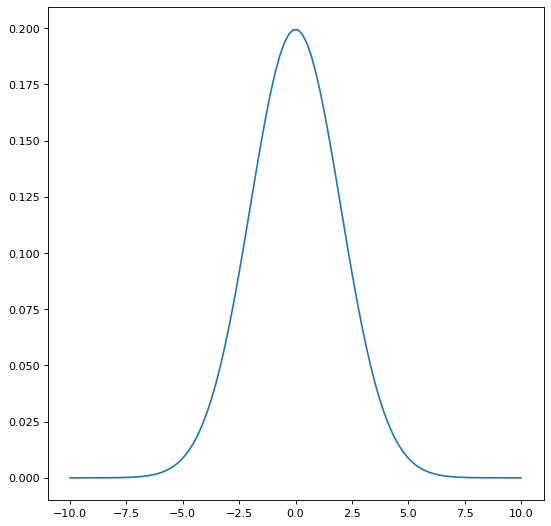

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

mu = 0.0
sigma = 2.0
x = np.linspace(-10., 10, 100)
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, norm(mu,sigma).pdf(x));

Now, take two values $x_1$ and $x_2$. The value taken by $y$ in $x_1$ is not independent of the value in $x_2$; we shall say that $y_1$ and $y_2$ are **correlated**. For example, the pressures $P$ in close $(l,M,T)$ values take values that are linked together.

Let's still suppose the pair $(y_1,y_2)$ follows a Gaussian distribution in $x_1$ and $x_2$, with mean $(\mu_1,\mu_2)$. While the variance in the monovariate case was given by a single scalar $\sigma^2$, now it is given by a covariance matrix $\Sigma = \left[\begin{array}{cc} \sigma_{11} & \sigma_{12}\\ \sigma_{12} & \sigma_{22} \end{array}\right]$ that depicts how the distribution spreads in the $(y_1,y_2)\in\mathbb{R}^2$ plane.

$$\left[\begin{array}{c}y_1\\y_2\end{array}\right] \sim \mathcal{N}\left( \left[\begin{array}{c} \mu_1\\\mu_2\end{array}\right], \Sigma\right)$$

mu = [0.0, 0.0]
sigma:
[[2.  0.4]
 [0.4 0.5]]


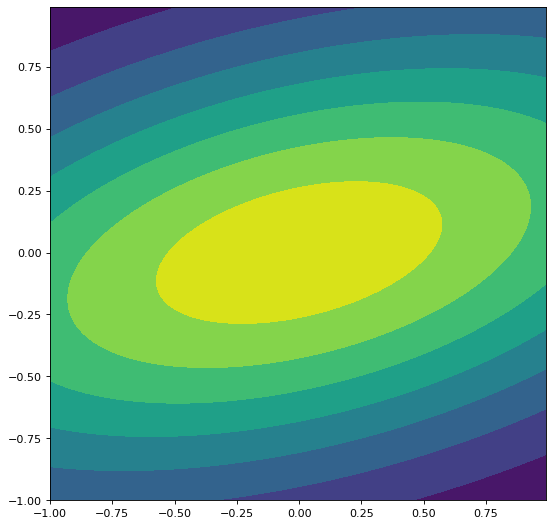

In [2]:
from scipy.stats import multivariate_normal
x,y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))
mu = [0.0, 0.0]
sigma = np.array([[2.0, 0.4], [0.4, 0.5]])
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.contourf(x, y, multivariate_normal(mu, sigma).pdf(pos));
print("mu =",mu)
print("sigma:")
print(sigma)

The covariance matrix indicates how the values of $y_1$ are centered around $\mu_1$ (through $\sigma_{11}$) and correlated with the value of $y_2$ (through $\sigma_{12}$). In particular, $\sigma_{12}$ indicates how similar the evolution of $y_1$ and $y_2$ are. Suppose we measure a sample $(\hat{y}_1, \hat{y}_2)$:
- having $\sigma_{12}>0$ indicates that if $\hat{y}_1>\mu_1$ then it is likely that $\hat{y}_2>\mu_2$ in a proportional fashion,
- conversely $\sigma_{12}<0$ indicates that $\hat{y}_1$ and $\hat{y}_2$ evolve in opposite directions relatively to their respective means,
- $\sigma_{12}=0$ means that $y_1$ and $y_2$ are independent: a sample of the former gives no information about how likely it is that the latter is greater or smaller than its mean.

If there are $N$ such points $x_i$, and we assume again a Gaussian distribution of $y$, we end up with a mean $(\mu_1,\ldots,\mu_N)$ and a covariance matrix $\Sigma = \left[\begin{array}{ccc} \sigma_{11} & \ldots & \sigma_{1N}\\ \vdots & \ddots & \vdots \\ \sigma_{1N} & \ldots & \sigma_{NN} \end{array}\right]$.

$$\left[\begin{array}{c}y_1\\ \vdots\\y_N \end{array}\right] \sim \mathcal{N}\left( \left[\begin{array}{c} \mu_1\\ \vdots \\ \mu_N\end{array}\right], \Sigma\right)$$

Let's generalize to any number of points:
- The mean becomes $\mu(x)$
- The covariance matrix can be obtained through a **covariance kernel** $k(x,x')$

For a finite set of points $(x_1,\ldots,x_N)$, the corresponding $(y_1,\ldots,y_N)$ follow a Gaussian distribution of mean $(\mu(x_1),\ldots,\mu(x_N))$ and of covariance matrix $\Sigma = \left[\begin{array}{ccc} k(x_1,x_1) & \ldots & k(x_1,x_N)\\ \vdots & \ddots & \vdots \\ k(x_1,x_N) & \ldots & k(x_N,x_N) \end{array}\right]$.

$$\left[\begin{array}{c}y_1\\ \vdots\\y_N \end{array}\right] \sim \mathcal{N}\left( \left[\begin{array}{c} \mu(x_1)\\ \vdots \\ \mu(x_N)\end{array}\right], \Sigma\right)$$

The information of $\mu(x)$ and $k(x,x')$ defines a **Gaussian Process**. If we were able to learn a certain hidden function $f$ as a Gaussian Process, not only would we have the average function that fits $f$ best, but we would also have the probability that any other function fits $f$. In other words, in any new point $x$, we would have the average prediction $\mu(x)$ but also an **uncertainty estimation** through the variance estimate $\sigma(x)$.

# <a id="sec2"></a>2. Back to the regression problem

So we assume that $y$ is drawn from a Gaussian Process.

Recall that $\mu(x)$ is the mean of the distribution in $x$ and that $k(x,x')$ describes how similar the values of $y$ and $y'$ (resp. in $x$ and $x'$) are likely to be spread around their respective means.

To make things simple, assume that the Gaussian Process describing $f$ has mean zero, so $\mu(x)=0$ everywhere. So what relates an observation to another is just the covariance function $k(x,x')$.

A common covariance function is the so-called **squared exponential**:
$$k(x,x') = \sigma^2 e^{-\frac{(x-x')^2}{2 l^2}}$$

With this covariance function, the correlation between $y$ and $y'$ is high when $x$ and $x'$ are close. As $x$ and $x'$ get further from each other, $y$ and $y'$ tend to become independent.

Since we assume that the observed data $\left\{(x_i,y_i)\right\}_{i=1...N}$ are drawn from a Gaussian distribution and that any new point $(x,y)$ should be drawn from that distribution too, we can write:

$$\left[\begin{array}{c}y_1\\ \vdots\\y_N \\y \end{array}\right] \sim \mathcal{N}\left( 0_{N+1}, \left[\begin{array}{cccc}
k(x_1,x_1) & \ldots & k(x_1,x_N) & k(x_1, x)\\ 
\vdots     & \ddots & \vdots     & \vdots \\
k(x_1,x_N) & \ldots & k(x_N,x_N) & k(x_N,x)\\
k(x_1, x)  & \ldots & k(x_N,x)   & k(x,x)
\end{array}\right] \right)$$

(where $0_{N+1}$ is the $N+1$ dimensional zero vector)

The line above simply states that all points, both the observed data points and the new points on which we wish to make a prediction, are drawn according to the same Gaussian Process. Let's simplify the writing using vector notation. Let's write:
- the data points $\mathbf{y} = \left[y_1,\ldots,y_N\right]$ and $\mathbf{x} = \left[x_1,\ldots,x_N\right]$, 
- the data covariance matrix $K = \left[\begin{array}{ccc}
k(x_1,x_1) & \ldots & k(x_1,x_N)\\ 
\vdots     & \ddots & \vdots\\
k(x_1,x_N) & \ldots & k(x_N,x_N)
\end{array}\right]$
- The cross-covariance vector $K_*(x) = \left[k(x_1, x), \ldots, k(x_N,x)\right]$

Then we have:
$$\left[\begin{array}{c}\mathbf{y}\\y \end{array}\right] \sim \mathcal{N}\left( 0_{N+1}, \left[\begin{array}{cc}
K & K_*(x)^T\\ 
K_*(x) & k(x,x)
\end{array}\right] \right)$$

Let's take a step back. What we have written so far is the probability $\mathbb{P}(\mathbf{y},y|\mathbf{x},x)$. But what we are interested in is the posterior distribution $\mathbb{P}(y|\mathbf{x},\mathbf{y},x)$; that is "the probability of the prediction $y$, given the data $(\mathbf{x},\mathbf{y})$". So let's use Bayes theorem:

$$\mathbb{P}(y|\mathbf{x},\mathbf{y},x) = \frac{\mathbb{P}(\mathbf{y},y|\mathbf{x},x)}{\mathbb{P}(\mathbf{y}|\mathbf{x},x)}$$

It appears that because we have assumed that the values were drawn from a Gaussian Process, this posterior follows a Gaussian distribution too:
$$\mathbb{P}(y|\mathbf{x},\mathbf{y},x) = \mathcal{N}\left( K_*(x)K^{-1} \mathbf{y}, k(x,x) - K_*(x) K^{-1} K_*(x)^T\right)$$

Consequently, our best estimate for $y$ is the mean of this distribution:
$$\bar{y} = K_*(x) K^{-1} \mathbf{y}$$

And the uncertainty in this estimate is captured by the variance:
$$\sigma(y)^2 = k(x,x)- K_*(x)K^{-1}K_*(x)^T$$

<div class="alert alert-success"> 
Given the input data $\mathbf{y} = \left[y_1,\ldots,y_N\right]$ and $\mathbf{x} = \left[x_1,\ldots,x_N\right]$, and given a covariance kernel $k(x,x')$, a Gaussian Process regressor estimates the distribution of $y(x)$ as a Gaussian $\mathcal{N}(\mu,\sigma)$ with:
<ul>
<li> $\mu = K_*(x)K^{-1} \mathbf{y}$
<li> $\sigma(y)^2 = k(x,x) - K_*(x)K^{-1}K_*(x)^T$
</ul>
where:
<ul>
<li> $K = \left[\begin{array}{ccc}
k(x_1,x_1) & \ldots & k(x_1,x_N)\\ 
\vdots     & \ddots & \vdots\\
k(x_1,x_N) & \ldots & k(x_N,x_N)
\end{array}\right]$
<li>$K_*(x) = \left[k(x_1, x), \ldots, k(x_N,x)\right]$
</ul>
</div>

Let's take a concrete example.

Suppose the hidden function we want to learn is $f(x) = x \sin(x)$.

Suppose the observation is drawn as $y = f(x) + \mathcal{N}(0, \sigma_n^2)$.

Let's draw 10 data samples and try to obtain the best fit function and confidence intervals.

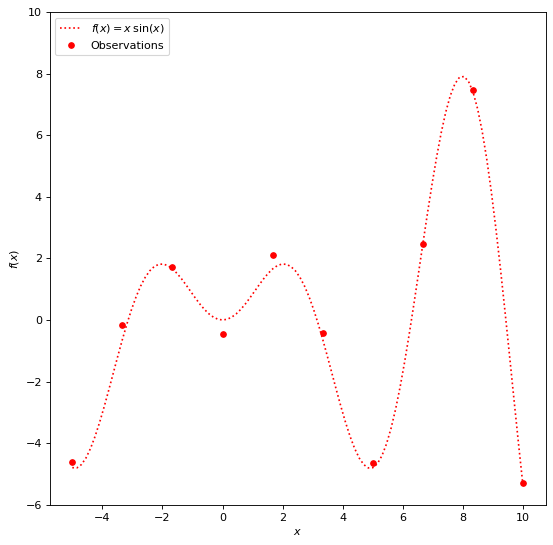

In [3]:
def func(x):
    return x*np.sin(x)

sigma_noise = 0.3
def observation(x):
    return func(x) + np.random.normal(0,sigma_noise,x.shape[0])

X = np.linspace(-5,10,10)
N = X.shape[0]
Y = observation(X)
x = np.linspace(-5,10,100)


fig=plt.figure(figsize=(8,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, func(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, Y, 'r.', markersize=10, label=u'Observations')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-6, 10)
plt.legend(loc='upper left');

#### Covariance Kernels

First, we can implement the simplest quadratic kernel: 
$$k(x_1, x_2) = \sigma_k^2\  (x_1 . x_2^{\top})$$

Where $ \sigma_k$ is the variance of the process.

In [4]:
sigma_kernel = 0.2
def kernel(x1,x2,sigma_kernel,l,sigma_noise):
    k = sigma_kernel**2*np.dot(x1,x2.T)
    return k + sigma_noise*(x1==x2)

We can have a variety of other kernels that are more complicated and more realistic to model the uncertainties, for example: 
\begin{align}
\exp\left( -\frac12 \left(\frac{\lVert x - y \rVert}{l}\right)^\beta \right)
&\qquad\text{ for $0 < \beta \le 2$ ($\beta = 2$ is square exponential, $\beta = 1$ is absolute exponential)}
\\
\lVert x - z_0 \rVert + \lVert y - z_0 \rVert - \lVert x - y \rVert
&\qquad\text{ for any $z_0$ ("distance kernel")}
\\
\frac{1}{\sqrt{\lVert x - y \rVert^2 + c}}
&\qquad\text{ (inverse multiquadric)}
\\
\left( 1 + \frac{\lVert x - y \rVert^2}{2 \alpha \ell^2} \right)^{-\alpha}
&\qquad\text{ (rational quadratic; $\alpha \to \infty$ becomes Gaussian)}
\end{align}

In our case, we will use the square exponential kernel because it is a smooth kernel.

For our 1-dimensional example, this kernel writes as:
$$k(x_1, x_2) =  \sigma_k^2 \exp\left( -\frac{1}{2 l^2} \lVert x_1 - x_2 \rVert^2 \right).$$

Where $ \sigma_k$ is the variance of the process and $l$ is a correlation length.

<div class="alert alert-warning">
    
**Exercice:**<br>
Your turn to play. Define the kernel above in the cell below. Afterwards, we also want to add a noise but for this exercice, you just need to code the non-noisy part.
</div>

To find the best function, we need a covariance kernel. We will take the square exponential kernel with arbitrary $\sigma$ and $l$ parameters and will modify it slightly to account for the measurement noise $\sigma_n$. Then we simply apply the formula above.


In [5]:
sigma_kernel = 0.2
l=0.3

In [30]:
# %load solutions/code4.py
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).
def kernel(x1,x2,sigma_kernel,l,sigma_noise):
    ### WRITE YOUR CODE HERE
    k =  sigma_kernel**2 * np.exp(-1/(2*l**2) * np.linalg.norm(x1-x2)**2)
    return k + sigma_noise*(x1==x2)


<div class="alert alert-warning">
    
**Exercice:**<br>
Define two functions `compute_K(X,sigma_kernel,l,sigma_noise)` (that returns the covariance matrix) and `GPpredict(x_new, x_data, y_data, Kinv)` (that returns the mean and standard deviation of the output value) below.
</div>

In [38]:
# %load solutions/code5.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

def compute_K(X,sigma_kernel,l,sigma_noise):
    ### FILL THE VALUES OF K
    K = np.zeros((len(X), len(X)))
    for i in range (len(X)):
        for j in range (len(X)):
            K[i, j] = kernel(X[i], X[j], sigma_kernel, l, sigma_noise)
    return K

def GPpredict(x_new, x_data, y_data, Kinv):
    ### COMPUTE MEAN AND STANDARD DEVIATION
    K_star = np.array([kernel(x_new[0,0], x_data[i], sigma_kernel,l,sigma_noise) for i in range(len(x_data))])
    mu = np.dot(np.dot(K_star, Kinv), y_data)
    sigma = kernel(x_new[0,0], x_new[0,0], sigma_kernel, l, sigma_noise) - np.dot(np.dot(K_star, Kinv), np.transpose(K_star))
    return mu, sigma



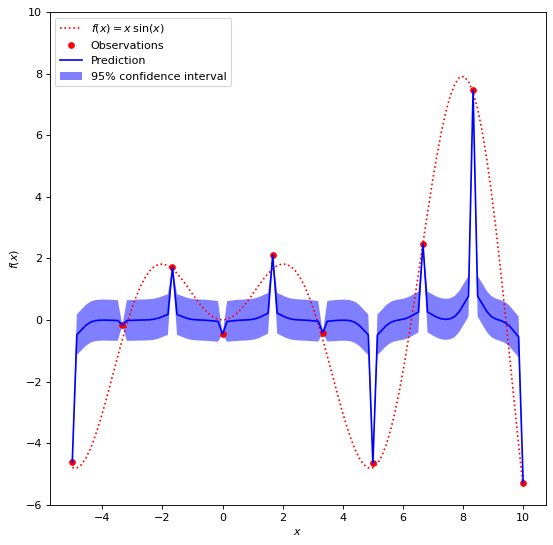

In [39]:
Kinv = np.linalg.inv(compute_K(X,sigma_kernel,l,sigma_noise))

x = np.linspace(-5,10,100)
y = np.zeros(x.shape)
sigma = np.zeros(x.shape)
for i in range(x.shape[0]):
    y[i], sigma[i] = GPpredict(x[i].reshape(-1,1), X, Y, Kinv)

fig=plt.figure(figsize=(8,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, func(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, Y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y - 1.9600 * sigma,
                        (y + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-6, 10)
plt.legend(loc='upper left');

That's quite disappointing. Indeed, the (blue) learned curve goes through the data points but it is far from the (red) original function. An interesting feature however is that the uncertainty reduces almost to zero around the data points and strongly increases elsewhere.

What happened? It seems we made a poor arbitrary choice of kernel parameters. For instance taking $l=0.3$ implies that values $y$ and $y'$ for two points $x$ and $x'$ quickly tend to be independent and so the "influence" of a data point (a red point) does not extend far.

Let's re-run this experiment with other parameters.

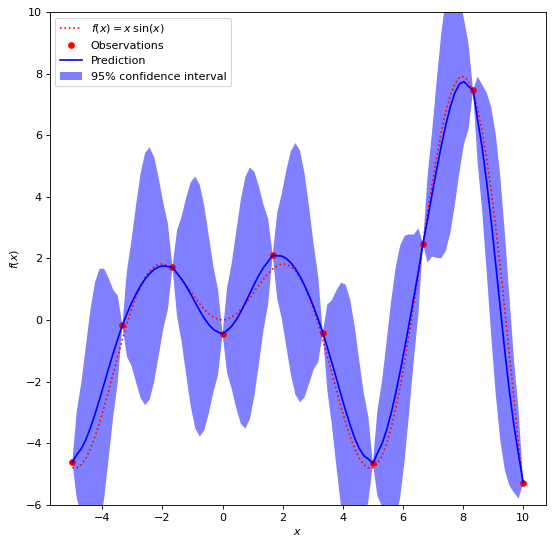

In [40]:
sigma_kernel = 3
l=1

Kinv = np.linalg.inv(compute_K(X,sigma_kernel,l,sigma_noise))

def GPpredict(x_new, x_data, y_data, Kinv):
    N = y_data.shape[0]
    Kstar = np.zeros((1,N))
    for i in range(N):
        Kstar[0,i] = kernel(x_data[i], x_new, sigma_kernel, l, sigma_noise)
    mu = Kstar @ Kinv @ y_data
    sigma = kernel(x_new,x_new,sigma_kernel,l,sigma_noise) - Kstar @ Kinv @ Kstar.T
    return mu, sigma

x = np.linspace(-5,10,100)
y = np.zeros(x.shape)
sigma = np.zeros(x.shape)
for i in range(x.shape[0]):
    y[i], sigma[i] = GPpredict(x[i], X, Y, Kinv)

fig=plt.figure(figsize=(8,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, func(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, Y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y - 1.9600 * sigma,
                        (y + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-6, 10)
plt.legend(loc='upper left');

This starts to look better. The blue curve fits the data points better but it's still not perfect and the uncertainty between data points is actually quite large.


<div class="alert alert-warning">
    
**Exercice:**<br>
Test several values of $[l, \sigma_f]$ with $l$ being geometrically the length-scale (of oscillations) and  $\sigma_f$ the amplitude. Compare the square exponential and quadratic kernels and conclude.
</div>


We could wish for an automated way of tuning these kernel parameters. Let's call them $\theta$.

One way to do that is to search for the value of $\theta$ that maximizes the probability of the observed $\mathbf{y}$ given the inputs $\mathbf{x}$. In other words, to find the best $\theta$, we search for the one that explains best the data that we already know, and then use it to make predictions on new points. That is called **Marginal Likelihood Maximization**.
$$\max_\theta \mathbb{P}(\mathbf{y}|\mathbf{x})$$

Fortunately for use, scikit-learn includes all these operations in a single procedure.

In [41]:
from sklearn.gaussian_process import GaussianProcessRegressor
gp = GaussianProcessRegressor()
X=X.reshape(-1,1)
Y=Y.reshape(-1,1)
gp.fit(X,Y)

GaussianProcessRegressor()

[Hyperparameter(name='k1__constant_value', value_type='numeric', bounds='fixed', n_elements=1, fixed=True), Hyperparameter(name='k2__length_scale', value_type='numeric', bounds='fixed', n_elements=1, fixed=True)]


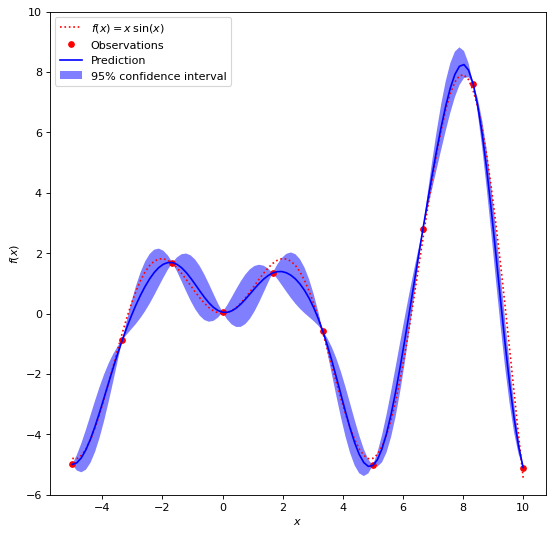

In [56]:
x = np.linspace(-5,10,100)
#x = np.linspace(-25,40,100)
y = np.zeros(x.shape)
sigma = np.zeros(x.shape)
for i in range(x.shape[0]):
    y[i], sigma[i] = gp.predict(x[i].reshape(-1,1), return_std=True)

fig=plt.figure(figsize=(8,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, func(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, Y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y - 1.9600 * sigma,
                        (y + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-6, 10)
plt.legend(loc='upper left');
print(gp.kernel_.hyperparameters)

Now that's better. Although the correct function was not found exactly, given the few data points we had it's already a good fit.

Let's summarize a few properties of Gaussian Processes.

<div class="alert alert-success">
<ul>
<li> Gaussian processes are an offline method
<li> They are an optimal method (in the sense of Bayesian inference)
<li> They provide a best fit function, but also error bounds
<li> Given $N$ data points, they require the inversion of an $N\times N$ covariance matrix (complexity in $O(N^3)$)
<li> The kernel encodes the prior knowledge about the function's behaviour.
<li> Careful choice / design of kernels can make GPs a very powerful tool... but can also make them very unstable computationally.
</ul>
</div>

Let's illustrate this last property on a final example, with a periodic function and the "Exp-Sine-Squared" kernel that is commonly used for periodic functions.

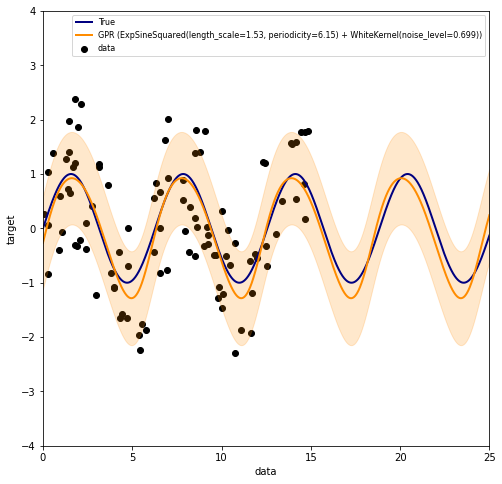

In [12]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

# Generate sample data
rng = np.random.RandomState(0)
X = 15 * rng.rand(100, 1)
y = np.sin(X).ravel()
y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise

# GP training
gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel)
#gpr = GaussianProcessRegressor()
gpr.fit(X, y)

# GP prediction
X_plot = np.linspace(0, 25, 10000)[:, None]
y_gpr, y_std = gpr.predict(X_plot, return_std=True)

# Plot
plt.figure(figsize=(8,8))
lw = 2
plt.scatter(X, y, c='k', label='data')
plt.plot(X_plot, np.sin(X_plot), color='navy', lw=lw, label='True')
plt.plot(X_plot, y_gpr, color='darkorange', lw=lw,
         label='GPR (%s)' % gpr.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr - y_std, y_gpr + y_std, color='darkorange',
                 alpha=0.2)
plt.xlabel('data')
plt.ylabel('target')
plt.xlim(0, 25)
plt.ylim(-4, 4)
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
plt.show()


# <a id="sec3"></a>3. Gaussian Processes for classification ?

It actually works exactly the same way. For binary classification problems, Gaussian Processes try to predict the probability of belonging to the first class (thus turning back to a regression problem).

More precisely, they try to build a hidden function $f(x)$ so that: 
$$\mathbb{P}(Y=0|X=x) = \frac{1}{1+e^{f(x)}}$$
Where $f$ is a Gaussian Process.

# <a id="sec4"></a> 4. Examples

## <a id="sec4-1"></a> 4.1 Spam or ham?

Let's illustrate that on the Ling-spam database.

In [21]:
from sys import path
path.append('../2 - Text data preprocessing')
import load_spam
spam_data = load_spam.spam_data_loader()
spam_data.load_data()
print("data loaded")

Xtrain, ytrain, Xtest, ytest = spam_data.split(2000)
print(Xtrain.shape)
print(Xtest.shape)

ModuleNotFoundError: No module named 'load_spam'

We have loaded a training set with 2000 examples. This means that the Gaussian Process training will require inverting a $2000\times2000$ matrix. Although this is still feasible in a few seconds or minutes, we are touching here a limitation of Gaussian Processes in their ability to scale up to large datasets.

<div class="alert alert-warning">
    
**Exercice:**<br>
Use scikit-learn to fit a [Gaussian Process classifier](http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc) to the spam data loaded above. Estimate the generalization score.<br>
Hint: you can use the `.toarray()` method of sparse matrices to get the corresponding dense matrix.
</div>

In [22]:
# %load solutions/code6.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

For a fair comparison, we can also try the training on the word count features rather than Tf-Idf ones. Although it would probably be more beneficial to search for a better kernel than the default squared exponential one.

<div class="alert alert-warning">
    
**Exercice:**<br>
Use scikit-learn to fit a Gaussian Process classifier to the raw word count data loaded below. Estimate the generalization score.
</div>

In [23]:
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat='wordcount')

NameError: name 'spam_data' is not defined

In [24]:
# %load solutions/code7.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

Let's keep this last classifier and identify which are the misclassified emails.

In [25]:
# Retrain
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat='wordcount')
spam_GP = GaussianProcessClassifier()
spam_GP.fit(Xtrain.toarray(),ytrain)

NameError: name 'spam_data' is not defined

In [26]:
# Find misclassified examples
ypredict = spam_GP.predict(Xtest.toarray())
misclass = np.not_equal(ypredict, ytest)
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
misclass_indices = [i for i, j in enumerate(misclass) if j == True]
print("Misclassified messages indices:", misclass_indices)

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [27]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix:")
print(confusion_matrix(ytest, ypredict))

Confusion matrix:


NameError: name 'ypredict' is not defined

In [28]:
# Check some misclassified mails
index = misclass_indices[0]+2000
print("Prediction:", spam_GP.predict(spam_data.word_count[index,:].toarray()))
spam_data.print_email(index)

NameError: name 'misclass_indices' is not defined

## <a id="sec4-2"></a> 4.2 NIST

In [29]:
from sklearn import datasets
%matplotlib inline
import matplotlib.pyplot as plt

digits = datasets.load_digits()
print(digits.data.shape)
print(digits.images.shape)
print(digits.target.shape)
print(digits.target_names)

X = digits.data
y = digits.target
Xtrain,Xtest = np.split(X,[1000])
ytrain,ytest = np.split(y,[1000])

(1797, 64)
(1797, 8, 8)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


In [30]:
from sklearn.utils import shuffle

def shuffle_and_split(X,y,n):
    X0,y0 = shuffle(X,y)
    Xtrain,Xtest = np.split(X0,[n])
    ytrain,ytest = np.split(y0,[n])
    return Xtrain, ytrain, Xtest, ytest

In [31]:
Xtrain, ytrain, Xtest, ytest = shuffle_and_split(X,y,1000)
print(Xtrain.shape)
print(ytrain.shape)
digits_gp = GaussianProcessClassifier()
digits_gp.fit(Xtrain,ytrain)
prediction = digits_gp.predict(Xtest)
#print("Training error:", np.sum(np.not_equal(prediction,ytest))/len(ytest))
print("Generalization error:", np.sum(np.not_equal(prediction,ytest))/len(ytest) )
print("Generalization score:", digits_gp.score(Xtest,ytest))
print("Confusion matrix:")
print(confusion_matrix(ytest, prediction))

(1000, 64)
(1000,)
Generalization error: 0.8996235884567126
Generalization score: 0.10037641154328733
Confusion matrix:
[[ 0  0  0  0  0  0  0  0  0 78]
 [ 0  2  0  0  0  0  0  0  0 77]
 [ 0  0  0  0  0  0  0  0  0 89]
 [ 0  0  0  0  0  0  0  0  0 79]
 [ 0  0  0  0  0  0  0  0  0 86]
 [ 0  0  0  0  0  0  0  0  0 75]
 [ 0  0  0  0  0  0  0  0  0 79]
 [ 0  0  0  0  0  0  0  0  0 76]
 [ 0  0  0  0  0  0  0  0  0 78]
 [ 0  0  0  0  0  0  0  0  0 78]]


A perfect illustration that (often) ML methods don't work out-of-the-box and require some engineering knowledge just like any other modeling method. Here for example, a data scientist might investigate the kernel's properties, the marginal likelihood optimization procedure, the data distribution..., while the computer vision expert might question the use of pixel data as input.

For instance, try `digits_gp = GaussianProcessClassifier(multi_class="one_vs_one")` and try to explain what has changed.

# <a id="sec4"></a> 4.3 Cancer mortality Examples

The OLS regression challenge tasks you with predicting cancer mortality rates for US counties. The dataset contains data from cancer.gov, clinicaltrials.gov, and the American Community Survey. It is in CSV format and includes the following information about cancer in the US: death rates, reported cases, US county name, income per county, population, demographics and more.  

[Dataset for cancer mortality](https://data.world/nrippner/ols-regression-challenge)

**Question** :
- What is the main limitation in using GP with this dataset ?
- Using GP, make a predictor on the target variable
- What are the main possible improvements ?


In [ ]:
import pandas as pd
pd.read_csv("../data/cancer/cancer_reg.csv",encoding = "ISO-8859-1")